# Linear Regression Analysis: Predicting Social Media Addiction Score

This notebook uses linear regression to predict students' social media addiction scores. The analysis includes several scenarios:
- Feature selection (with and without)
- Normalization (with and without)
- Parameter tuning (regularization)
- Comparison between raw and preprocessed datasets

In [68]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [69]:
# Helper Functions
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_name="Model"):
    """Train a linear regression model and return performance metrics."""
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    
    return model, y_pred, metrics

def print_metrics(metrics, model_name, n_features=None):
    """Print model performance metrics in a consistent format."""
    r2, mae, rmse = metrics['R2'], metrics['MAE'], metrics['RMSE']
    
    if n_features:
        print(f"Features used: {n_features}")
    print(f"R² Score: {r2:.4f} ({r2*100:.2f}% accuracy)")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

def create_comparison_visualization(results_dict, title, x_label="Method", figsize=(14, 6)):
    """Create standardized comparison visualizations."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    methods = list(results_dict.keys())
    r2_scores = [results_dict[method]['R2'] for method in methods]
    mae_scores = [results_dict[method]['MAE'] for method in methods]
    
    colors = ['#2E86AB', '#A23B72'] if len(methods) == 2 else ['#2E86AB', '#F18F01', '#A23B72']
    
    # R² Score Comparison
    bars1 = ax1.bar(methods, r2_scores, color=colors, alpha=0.8, width=0.6)
    ax1.set_title('R² Score Comparison', fontweight='bold')
    ax1.set_ylabel('R² Score')
    ax1.set_ylim(min(r2_scores) - 0.005, max(r2_scores) + 0.005)
    for i, v in enumerate(r2_scores):
        ax1.text(i, v + 0.001, f'{v:.4f}\n({v*100:.2f}%)', ha='center', fontweight='bold', fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # MAE Comparison
    bars2 = ax2.bar(methods, mae_scores, color=colors, alpha=0.8, width=0.6)
    ax2.set_title('Mean Absolute Error (Lower = Better)', fontweight='bold')
    ax2.set_ylabel('MAE')
    for i, v in enumerate(mae_scores):
        ax2.text(i, v + 0.001, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def find_optimal_k(X_train, X_test, y_train, y_test, k_values):
    """Find optimal k value for SelectKBest feature selection."""
    best_k, best_r2, results = None, 0, {}
    
    for k in k_values:
        if k <= X_train.shape[1]:
            selector = SelectKBest(score_func=f_regression, k=k)
            X_train_selected = selector.fit_transform(X_train, y_train)
            X_test_selected = selector.transform(X_test)
            
            _, _, metrics = train_and_evaluate_model(X_train_selected, X_test_selected, y_train, y_test)
            r2 = metrics['R2']
            
            print(f"k={k:2d}: R² = {r2:.4f} ({r2*100:.2f}%)")
            results[k] = r2
            
            if r2 > best_r2:
                best_r2 = r2
                best_k = k
    
    return best_k, best_r2, results

## 1. Data Preparation

Load the feature-engineered dataset and prepare it for analysis.

In [70]:
# Load and prepare data
preprocessed_path = '../dataset/Students_Social_Media_Addiction_Feature_Engineered.csv'
df_preprocessed = pd.read_csv(preprocessed_path)

print(f"Dataset shape: {df_preprocessed.shape}")

# Define configuration
TARGET_COL = 'Addicted_Score'
EXCLUDE_COLS = ['Student_ID', 'Gender', 'Academic_Level', 'Country', 
                'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']

# Prepare features and target
X = df_preprocessed.drop(columns=[TARGET_COL] + EXCLUDE_COLS)
y = df_preprocessed[TARGET_COL]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Dataset shape: (705, 25)
Features shape: (705, 17)
Target shape: (705,)
Training set: (564, 17), Test set: (141, 17)


## 2. Feature Selection Comparison

Compare linear regression performance with and without feature selection using SelectKBest.

In [71]:
# Feature Selection Comparison: No Selection vs SelectKBest
print("="*60)
print("FEATURE SELECTION COMPARISON")
print("="*60)

feature_selection_results = {}

# 1. No Feature Selection (All Features)
print("\n1. NO FEATURE SELECTION (All Features)")
print("-" * 40)

lr_all, y_pred_all, metrics_all = train_and_evaluate_model(X_train, X_test, y_train, y_test)
feature_selection_results['No Feature Selection'] = {**metrics_all, 'n_features': X_train.shape[1]}
print_metrics(metrics_all, "All Features", X_train.shape[1])

# 2. SelectKBest Feature Selection with k optimization
print("\n2. SELECTKBEST FEATURE SELECTION")
print("-" * 40)

k_values = [5, 7, 9, 11, 13, 15]
best_k, best_r2, k_results = find_optimal_k(X_train, X_test, y_train, y_test, k_values)

print(f"\nOptimal k value: {best_k} features (R² = {best_r2:.4f})")

# Apply optimal SelectKBest
selector_best = SelectKBest(score_func=f_regression, k=best_k)
X_train_best = selector_best.fit_transform(X_train, y_train)
X_test_best = selector_best.transform(X_test)

lr_best, y_pred_best, metrics_best = train_and_evaluate_model(X_train_best, X_test_best, y_train, y_test)
feature_selection_results['SelectKBest'] = {**metrics_best, 'n_features': best_k}

print(f"\nSELECTKBEST FINAL RESULTS (k={best_k}):")
print_metrics(metrics_best, "SelectKBest", best_k)

# Show selected features
selected_features = X.columns[selector_best.get_support()]
print(f"\nSelected features: {list(selected_features)}")

FEATURE SELECTION COMPARISON

1. NO FEATURE SELECTION (All Features)
----------------------------------------
Features used: 17
R² Score: 0.9558 (95.58% accuracy)
MAE: 0.2445
RMSE: 0.3324

2. SELECTKBEST FEATURE SELECTION
----------------------------------------
k= 5: R² = 0.9536 (95.36%)
k= 7: R² = 0.9546 (95.46%)
k= 9: R² = 0.9571 (95.71%)
k=11: R² = 0.9555 (95.55%)
k=13: R² = 0.9559 (95.59%)
k=15: R² = 0.9550 (95.50%)

Optimal k value: 9 features (R² = 0.9571)

SELECTKBEST FINAL RESULTS (k=9):
Features used: 9
R² Score: 0.9571 (95.71% accuracy)
MAE: 0.2425
RMSE: 0.3276

Selected features: ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Adequate_Sleep', 'SM_Impact_Score', 'Lifestyle_Balance', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low']



DETAILED FEATURE SELECTION ANALYSIS

ALL FEATURES RANKED BY IMPORTANCE (F-Score):
Rank Feature                        F-Score      Selected  
------------------------------------------------------------
1    Mental_Health_Score            4694.49      YES        *
2    Conflicts_Over_Social_Media    3590.02      YES        *
3    SM_Impact_Score                2882.08      YES        *
4    Mental_Health_Risk_Low         1752.50      YES        *
5    Lifestyle_Balance              1380.67      YES        *
6    Avg_Daily_Usage_Hours          1269.06      YES        *
7    Sleep_Hours_Per_Night          789.26       YES        *
8    Mental_Health_Risk_Medium      595.11       YES        *
9    Adequate_Sleep                 466.34       YES        *
10   Usage_Category_Medium          372.76       NO        
11   Usage_Category_Very High       284.61       NO        
12   Age                            13.62        NO        
13   Academic_Level_Encoded         3.50         NO       

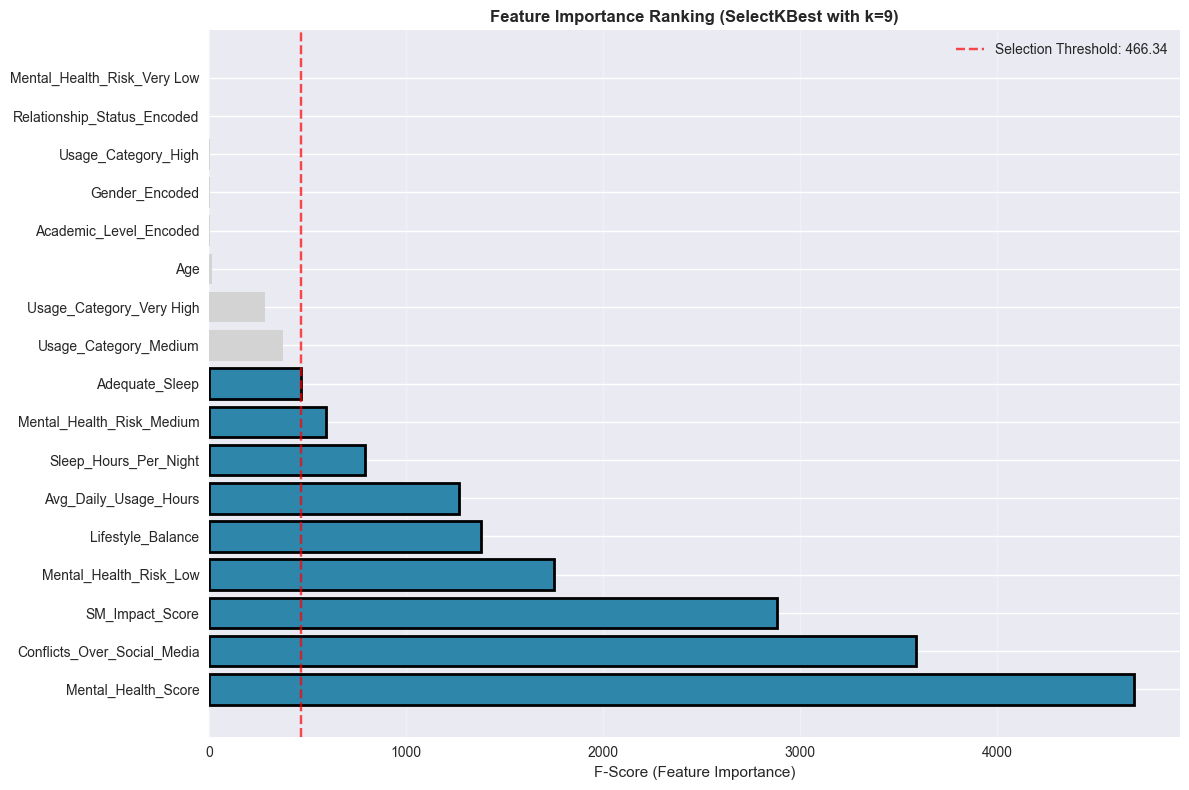


INTERPRETATION:
• F-Score measures the linear relationship between each feature and the target
• Higher F-Score = stronger predictive power for linear regression
• SelectKBest chose the top 9 features based on F-Score ranking
• Blue bars = Selected features, Gray bars = Rejected features


In [72]:
# Detailed Feature Analysis: What SelectKBest Actually Selects
print("\n" + "="*60)
print("DETAILED FEATURE SELECTION ANALYSIS")
print("="*60)

# Get feature scores and rankings
feature_scores = selector_best.scores_  # F-scores from SelectKBest
feature_support = selector_best.get_support()  # Boolean mask of selected features
selected_indices = selector_best.get_support(indices=True)  # Indices of selected features

# Create comprehensive feature analysis
all_features = X.columns.tolist()
feature_analysis = []

for i, (feature, score, selected) in enumerate(zip(all_features, feature_scores, feature_support)):
    feature_analysis.append({
        'Feature': feature,
        'F_Score': score,
        'Selected': selected,
        'Rank': None  # Will be filled below
    })

# Sort by F-score (descending) and assign ranks
feature_analysis.sort(key=lambda x: x['F_Score'], reverse=True)
for rank, item in enumerate(feature_analysis, 1):
    item['Rank'] = rank

print(f"\nALL FEATURES RANKED BY IMPORTANCE (F-Score):")
print(f"{'Rank':<4} {'Feature':<30} {'F-Score':<12} {'Selected':<10}")
print("-" * 60)

for item in feature_analysis:
    feature = item['Feature']
    score = item['F_Score']
    selected = "YES" if item['Selected'] else "NO"
    rank = item['Rank']
    
    # Highlight selected features
    if item['Selected']:
        print(f"{rank:<4} {feature:<30} {score:<12.2f} {selected:<10} *")
    else:
        print(f"{rank:<4} {feature:<30} {score:<12.2f} {selected:<10}")

# Selected features summary
selected_features_info = [item for item in feature_analysis if item['Selected']]
print(f"\nSELECTED FEATURES SUMMARY (k={best_k}):")
print(f"{'Rank':<4} {'Feature':<30} {'F-Score':<12}")
print("-" * 50)

for item in selected_features_info:
    print(f"{item['Rank']:<4} {item['Feature']:<30} {item['F_Score']:<12.2f}")

# Statistical insights
selected_scores = [item['F_Score'] for item in selected_features_info]
rejected_scores = [item['F_Score'] for item in feature_analysis if not item['Selected']]

print(f"\nFEATURE SELECTION STATISTICS:")
print(f"Selected features - Mean F-Score: {np.mean(selected_scores):.2f}, Min: {min(selected_scores):.2f}, Max: {max(selected_scores):.2f}")
if rejected_scores:
    print(f"Rejected features - Mean F-Score: {np.mean(rejected_scores):.2f}, Min: {min(rejected_scores):.2f}, Max: {max(rejected_scores):.2f}")

# Feature importance visualization
plt.figure(figsize=(12, 8))
features_for_plot = [item['Feature'] for item in feature_analysis]
scores_for_plot = [item['F_Score'] for item in feature_analysis]
colors_for_plot = ['#2E86AB' if item['Selected'] else 'lightgray' for item in feature_analysis]

bars = plt.barh(range(len(features_for_plot)), scores_for_plot, color=colors_for_plot)
plt.yticks(range(len(features_for_plot)), features_for_plot)
plt.xlabel('F-Score (Feature Importance)')
plt.title(f'Feature Importance Ranking (SelectKBest with k={best_k})', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add selection threshold line
if rejected_scores:
    threshold = min(selected_scores)
    plt.axvline(x=threshold, color='red', linestyle='--', alpha=0.7, label=f'Selection Threshold: {threshold:.2f}')
    plt.legend()

# Highlight selected features
for i, (bar, item) in enumerate(zip(bars, feature_analysis)):
    if item['Selected']:
        bar.set_edgecolor('black')
        bar.set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nINTERPRETATION:")
print(f"• F-Score measures the linear relationship between each feature and the target")
print(f"• Higher F-Score = stronger predictive power for linear regression")
print(f"• SelectKBest chose the top {best_k} features based on F-Score ranking")
print(f"• Blue bars = Selected features, Gray bars = Rejected features")

In [73]:
# Quick Way to Check Selected Features
print("QUICK REFERENCE - SELECTED FEATURES:")
print("="*50)

# Method 1: Get selected feature names directly
selected_features = X.columns[selector_best.get_support()]
print(f"Selected features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

print(f"\nFeature Selection Summary:")
print(f"• Total available features: {len(X.columns)}")
print(f"• Features selected by SelectKBest: {len(selected_features)}")
print(f"• Features removed: {len(X.columns) - len(selected_features)}")
print(f"• Selection rate: {len(selected_features)/len(X.columns)*100:.1f}%")

# Method 2: Check if a specific feature is selected
print(f"\nCheck specific features:")
important_features = ['Mental_Health_Score', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night']
for feature in important_features:
    if feature in X.columns:
        is_selected = feature in selected_features.tolist()
        status = "SELECTED" if is_selected else "NOT SELECTED"
        print(f"  {feature}: {status}")

# Method 3: Get features with their scores
print(f"\nTop selected features with scores:")
feature_scores = dict(zip(X.columns, selector_best.scores_))
selected_with_scores = [(feat, feature_scores[feat]) for feat in selected_features]
selected_with_scores.sort(key=lambda x: x[1], reverse=True)

for i, (feature, score) in enumerate(selected_with_scores, 1):
    print(f"  {i}. {feature}: {score:.2f}")

QUICK REFERENCE - SELECTED FEATURES:
Selected features (9):
  1. Avg_Daily_Usage_Hours
  2. Sleep_Hours_Per_Night
  3. Mental_Health_Score
  4. Conflicts_Over_Social_Media
  5. Adequate_Sleep
  6. SM_Impact_Score
  7. Lifestyle_Balance
  8. Mental_Health_Risk_Medium
  9. Mental_Health_Risk_Low

Feature Selection Summary:
• Total available features: 17
• Features selected by SelectKBest: 9
• Features removed: 8
• Selection rate: 52.9%

Check specific features:
  Mental_Health_Score: SELECTED
  Avg_Daily_Usage_Hours: SELECTED
  Sleep_Hours_Per_Night: SELECTED

Top selected features with scores:
  1. Mental_Health_Score: 4694.49
  2. Conflicts_Over_Social_Media: 3590.02
  3. SM_Impact_Score: 2882.08
  4. Mental_Health_Risk_Low: 1752.50
  5. Lifestyle_Balance: 1380.67
  6. Avg_Daily_Usage_Hours: 1269.06
  7. Sleep_Hours_Per_Night: 789.26
  8. Mental_Health_Risk_Medium: 595.11
  9. Adequate_Sleep: 466.34



FEATURE SELECTION COMPARISON SUMMARY

Method               R² Score     Accuracy %   Features
-------------------------------------------------------
No Feature Selection 0.9558       95.58        17       
SelectKBest          0.9571       95.71        9        WINNER

WINNER: SelectKBest
Best R² Score: 0.9571 (95.71% accuracy)
Performance Improvement: 0.13%
SelectKBest with k=9 features outperforms using all 17 features!
Feature selection identified the most predictive features.


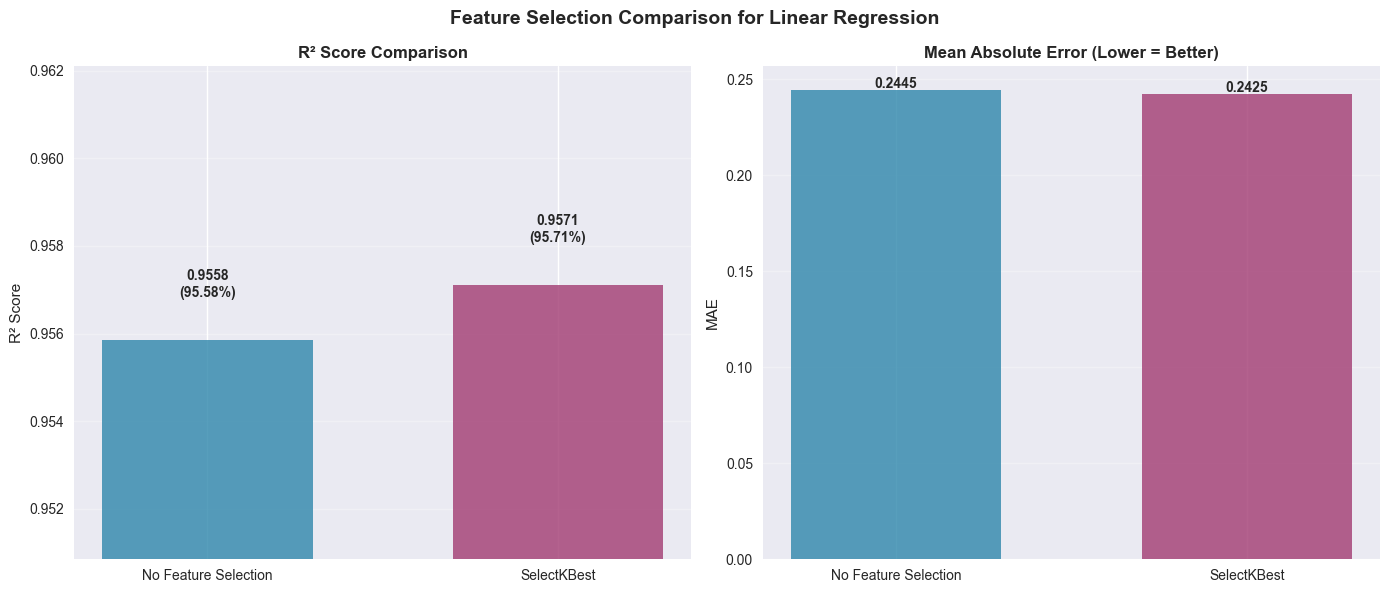

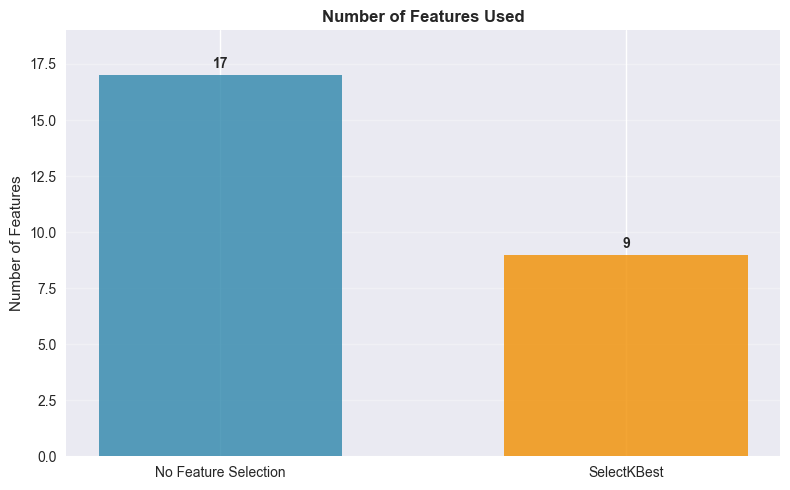


CONCLUSION: SelectKBest is the optimal approach for feature selection.


In [74]:
# Feature Selection Results Summary
print("\n" + "="*60)
print("FEATURE SELECTION COMPARISON SUMMARY")
print("="*60)

# Results table
print(f"\n{'Method':<20} {'R² Score':<12} {'Accuracy %':<12} {'Features':<8}")
print("-" * 55)

winner_r2 = max(feature_selection_results[k]['R2'] for k in feature_selection_results.keys())
for method, metrics in feature_selection_results.items():
    r2, n_feat = metrics['R2'], metrics['n_features']
    status = "WINNER" if r2 == winner_r2 else ""
    print(f"{method:<20} {r2:<12.4f} {r2*100:<12.2f} {n_feat:<8} {status}")

# Analysis
winner_method = max(feature_selection_results.keys(), key=lambda k: feature_selection_results[k]['R2'])
loser_r2 = min(feature_selection_results[k]['R2'] for k in feature_selection_results.keys())
improvement = ((winner_r2 - loser_r2) / loser_r2) * 100

print(f"\nWINNER: {winner_method}")
print(f"Best R² Score: {winner_r2:.4f} ({winner_r2*100:.2f}% accuracy)")
print(f"Performance Improvement: {improvement:.2f}%")

if winner_method == 'SelectKBest':
    print(f"SelectKBest with k={best_k} features outperforms using all {X_train.shape[1]} features!")
    print(f"Feature selection identified the most predictive features.")
else:
    print(f"Using all features performs best for this dataset.")
    print(f"All engineered features contribute meaningfully to the model.")

# Visualization
create_comparison_visualization(
    feature_selection_results, 
    'Feature Selection Comparison for Linear Regression'
)

# Add number of features visualization
methods = list(feature_selection_results.keys())
n_features = [feature_selection_results[method]['n_features'] for method in methods]

plt.figure(figsize=(8, 5))
colors = ['#2E86AB', '#F18F01']
bars = plt.bar(methods, n_features, color=colors, alpha=0.8, width=0.6)
plt.title('Number of Features Used', fontweight='bold')
plt.ylabel('Number of Features')
plt.ylim(0, max(n_features) + 2)
for i, v in enumerate(n_features):
    plt.text(i, v + 0.3, f'{v}', ha='center', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCONCLUSION: {winner_method} is the optimal approach for feature selection.")

## 3. Normalization Comparison with SelectKBest

Since SelectKBest proved optimal, we'll use it for comparing normalization approaches: No Normalization vs StandardScaler.

In [75]:
# Normalization Comparison Setup
print("="*60)
print("NORMALIZATION COMPARISON (using SelectKBest)")
print("="*60)

normalization_results = {}

# Use optimal SelectKBest features from previous analysis
print(f"Using SelectKBest with k={best_k} features (optimal from previous analysis)")

# Apply SelectKBest with optimal k
selector_norm = SelectKBest(score_func=f_regression, k=best_k)
X_train_selected = selector_norm.fit_transform(X_train, y_train)
X_test_selected = selector_norm.transform(X_test)

selected_feature_names = X.columns[selector_norm.get_support()]
print(f"Selected features: {list(selected_feature_names)}")

NORMALIZATION COMPARISON (using SelectKBest)
Using SelectKBest with k=9 features (optimal from previous analysis)
Selected features: ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Adequate_Sleep', 'SM_Impact_Score', 'Lifestyle_Balance', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low']


In [76]:
# Test Normalization Approaches
print("\n1. NO NORMALIZATION + SelectKBest")
print("-" * 40)

lr_no_norm, y_pred_no_norm, metrics_no_norm = train_and_evaluate_model(
    X_train_selected, X_test_selected, y_train, y_test
)
normalization_results['No Normalization'] = metrics_no_norm
print_metrics(metrics_no_norm, "No Normalization")

print("\n2. STANDARDSCALER + SelectKBest")
print("-" * 40)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

lr_scaled, y_pred_scaled, metrics_scaled = train_and_evaluate_model(
    X_train_scaled, X_test_scaled, y_train, y_test
)
normalization_results['StandardScaler'] = metrics_scaled
print_metrics(metrics_scaled, "StandardScaler")

# Show scaling effect
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)
print(f"\nFEATURE SCALING STATISTICS:")
print(f"Before scaling - Mean: {X_train_selected_df.mean().mean():.4f}, Std: {X_train_selected_df.std().mean():.4f}")
print(f"After scaling  - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")


1. NO NORMALIZATION + SelectKBest
----------------------------------------
R² Score: 0.9571 (95.71% accuracy)
MAE: 0.2425
RMSE: 0.3276

2. STANDARDSCALER + SelectKBest
----------------------------------------
R² Score: 0.9571 (95.71% accuracy)
MAE: 0.2425
RMSE: 0.3276

FEATURE SCALING STATISTICS:
Before scaling - Mean: 3.0933, Std: 1.2313
After scaling  - Mean: -0.0000, Std: 1.0000



NORMALIZATION COMPARISON SUMMARY

Method               R² Score     Accuracy %   MAE      RMSE    
-----------------------------------------------------------------
No Normalization     0.9571       95.71        0.2425   0.3276   TIE
StandardScaler       0.9571       95.71        0.2425   0.3276   TIE

RESULT: Both normalization approaches perform IDENTICALLY
R² Score: 0.9571 (95.71% accuracy)
Performance Difference: 0.000% (No difference)

FINDING: Normalization has NO IMPACT on this linear regression model!
The SelectKBest features (k=9) are already well-scaled.
Both approaches are equally valid - choose based on:
• No Normalization: Simpler pipeline, easier interpretation
• StandardScaler: Better for model consistency & future robustness


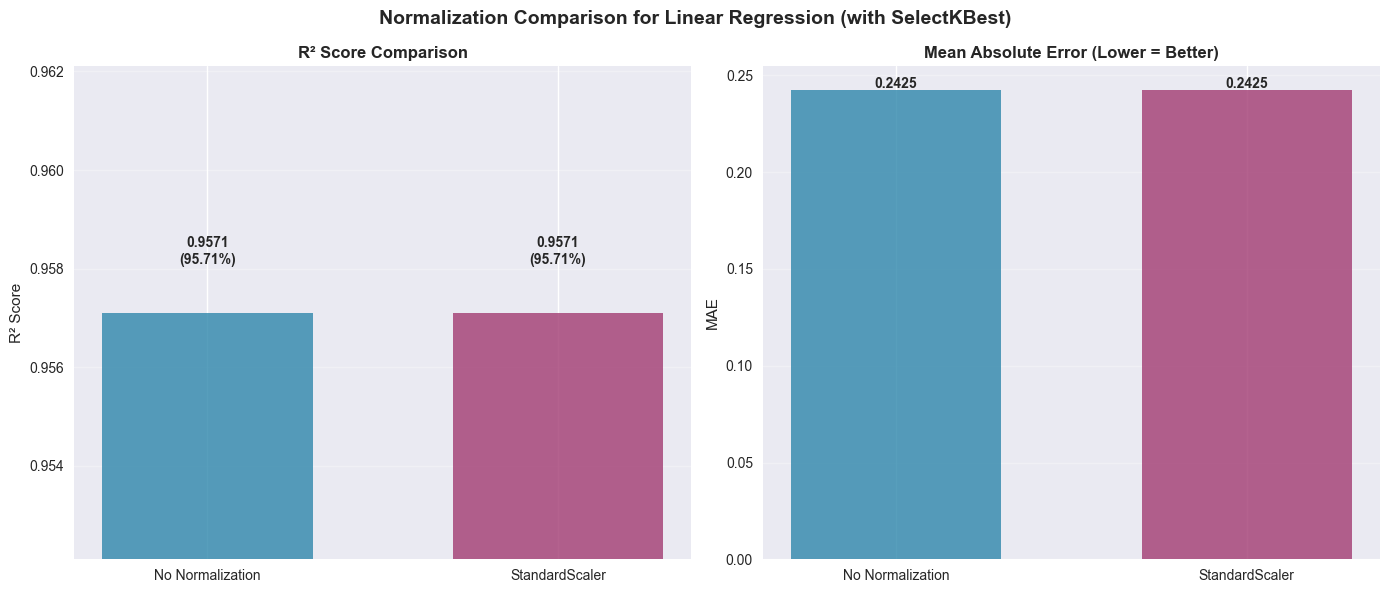

In [77]:
# Normalization Results Analysis
print("\n" + "="*60)
print("NORMALIZATION COMPARISON SUMMARY")
print("="*60)

# Results table
print(f"\n{'Method':<20} {'R² Score':<12} {'Accuracy %':<12} {'MAE':<8} {'RMSE':<8}")
print("-" * 65)

r2_values = [normalization_results[k]['R2'] for k in normalization_results.keys()]
max_r2, min_r2 = max(r2_values), min(r2_values)
is_tie = abs(max_r2 - min_r2) < 1e-10

for method, metrics in normalization_results.items():
    r2, mae, rmse = metrics['R2'], metrics['MAE'], metrics['RMSE']
    status = "TIE" if is_tie else ("WINNER" if r2 == max_r2 else "")
    print(f"{method:<20} {r2:<12.4f} {r2*100:<12.2f} {mae:<8.4f} {rmse:<8.4f} {status}")

# Analysis
if is_tie:
    print(f"\nRESULT: Both normalization approaches perform IDENTICALLY")
    print(f"R² Score: {max_r2:.4f} ({max_r2*100:.2f}% accuracy)")
    print(f"Performance Difference: 0.000% (No difference)")
    print(f"\nFINDING: Normalization has NO IMPACT on this linear regression model!")
    print(f"The SelectKBest features (k={best_k}) are already well-scaled.")
    print(f"Both approaches are equally valid - choose based on:")
    print(f"• No Normalization: Simpler pipeline, easier interpretation")
    print(f"• StandardScaler: Better for model consistency & future robustness")
    norm_winner = "No Normalization (recommended for simplicity)"
else:
    norm_winner = max(normalization_results.keys(), key=lambda k: normalization_results[k]['R2'])
    improvement = ((max_r2 - min_r2) / min_r2) * 100
    print(f"\nWINNER: {norm_winner}")
    print(f"Best R² Score: {max_r2:.4f} ({max_r2*100:.2f}% accuracy)")
    print(f"Performance Difference: {improvement:.3f}%")

# Visualization
create_comparison_visualization(
    normalization_results,
    'Normalization Comparison for Linear Regression (with SelectKBest)'
)

# 🔧 Regularization Analysis: Ridge, Lasso, and ElasticNet

This section explores regularized linear regression models to prevent overfitting and improve generalization. We'll compare:

- **Linear Regression** (no regularization) - baseline
- **Ridge Regression** (L2 regularization) - reduces coefficient magnitude
- **Lasso Regression** (L1 regularization) - feature selection + regularization  
- **ElasticNet** (L1 + L2 regularization) - combines both approaches

We'll use the optimal setup from previous analysis: **SelectKBest (k=9) features**.

In [78]:
# Regularization Models Comparison
# Using SelectKBest features (k=9) for fair comparison
regularization_results = {}

print("REGULARIZATION MODELS COMPARISON")
print("="*60)
print("Using SelectKBest features (k=9) - optimal from previous analysis")
print("All models use default alpha=1.0 for initial comparison")
print()

# 1. Linear Regression (No Regularization) - Baseline
print("1. LINEAR REGRESSION (No Regularization)")
print("-" * 45)
lr_baseline = LinearRegression()
lr_baseline.fit(X_train_best, y_train)
y_pred_baseline = lr_baseline.predict(X_test_best)

baseline_metrics = {
    'R2': r2_score(y_test, y_pred_baseline),
    'MAE': mean_absolute_error(y_test, y_pred_baseline),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_baseline))
}
regularization_results['Linear Regression'] = baseline_metrics
print_metrics(baseline_metrics, "Linear Regression (Baseline)")

# 2. Ridge Regression (L2 Regularization)
print("\n2. RIDGE REGRESSION (L2 Regularization)")
print("-" * 45)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_best, y_train)
y_pred_ridge = ridge_model.predict(X_test_best)

ridge_metrics = {
    'R2': r2_score(y_test, y_pred_ridge),
    'MAE': mean_absolute_error(y_test, y_pred_ridge),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge))
}
regularization_results['Ridge (α=1.0)'] = ridge_metrics
print_metrics(ridge_metrics, "Ridge Regression")

# 3. Lasso Regression (L1 Regularization)
print("\n3. LASSO REGRESSION (L1 Regularization)")
print("-" * 45)
lasso_model = Lasso(alpha=1.0, random_state=42, max_iter=2000)
lasso_model.fit(X_train_best, y_train)
y_pred_lasso = lasso_model.predict(X_test_best)

lasso_metrics = {
    'R2': r2_score(y_test, y_pred_lasso),
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lasso))
}
regularization_results['Lasso (α=1.0)'] = lasso_metrics
print_metrics(lasso_metrics, "Lasso Regression")

# Check feature selection effect of Lasso
lasso_selected_features = np.sum(lasso_model.coef_ != 0)
print(f"Features selected by Lasso: {lasso_selected_features} out of {len(selected_feature_names)}")

# 4. ElasticNet Regression (L1 + L2)
print("\n4. ELASTICNET REGRESSION (L1 + L2 Regularization)")
print("-" * 50)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=2000)
elasticnet_model.fit(X_train_best, y_train)
y_pred_elasticnet = elasticnet_model.predict(X_test_best)

elasticnet_metrics = {
    'R2': r2_score(y_test, y_pred_elasticnet),
    'MAE': mean_absolute_error(y_test, y_pred_elasticnet),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))
}
regularization_results['ElasticNet (α=1.0)'] = elasticnet_metrics
print_metrics(elasticnet_metrics, "ElasticNet Regression")

# Check feature selection effect of ElasticNet
elastic_selected_features = np.sum(elasticnet_model.coef_ != 0)
print(f"Features selected by ElasticNet: {elastic_selected_features} out of {len(selected_feature_names)}")

REGULARIZATION MODELS COMPARISON
Using SelectKBest features (k=9) - optimal from previous analysis
All models use default alpha=1.0 for initial comparison

1. LINEAR REGRESSION (No Regularization)
---------------------------------------------
R² Score: 0.9571 (95.71% accuracy)
MAE: 0.2425
RMSE: 0.3276

2. RIDGE REGRESSION (L2 Regularization)
---------------------------------------------
R² Score: 0.9570 (95.70% accuracy)
MAE: 0.2418
RMSE: 0.3282

3. LASSO REGRESSION (L1 Regularization)
---------------------------------------------
R² Score: 0.7886 (78.86% accuracy)
MAE: 0.5023
RMSE: 0.7273
Features selected by Lasso: 1 out of 9

4. ELASTICNET REGRESSION (L1 + L2 Regularization)
--------------------------------------------------
R² Score: 0.8343 (83.43% accuracy)
MAE: 0.4643
RMSE: 0.6440
Features selected by ElasticNet: 2 out of 9



REGULARIZATION COMPARISON SUMMARY

Model                     R² Score     Accuracy %   MAE      RMSE    
----------------------------------------------------------------------
Linear Regression         0.9571       95.71        0.2425   0.3276   WINNER
Ridge (α=1.0)             0.9570       95.70        0.2418   0.3282   
Lasso (α=1.0)             0.7886       78.86        0.5023   0.7273   
ElasticNet (α=1.0)        0.8343       83.43        0.4643   0.6440   

ANALYSIS:
• WINNER: Linear Regression
• Best R² Score: 0.9571 (95.71% accuracy)
• Performance Improvement: 21.368%

FEATURE SELECTION EFFECTS:
• Original features: 9
• Lasso selected: 1
• ElasticNet selected: 2
• Ridge: Uses all features (coefficients shrunk, not eliminated)


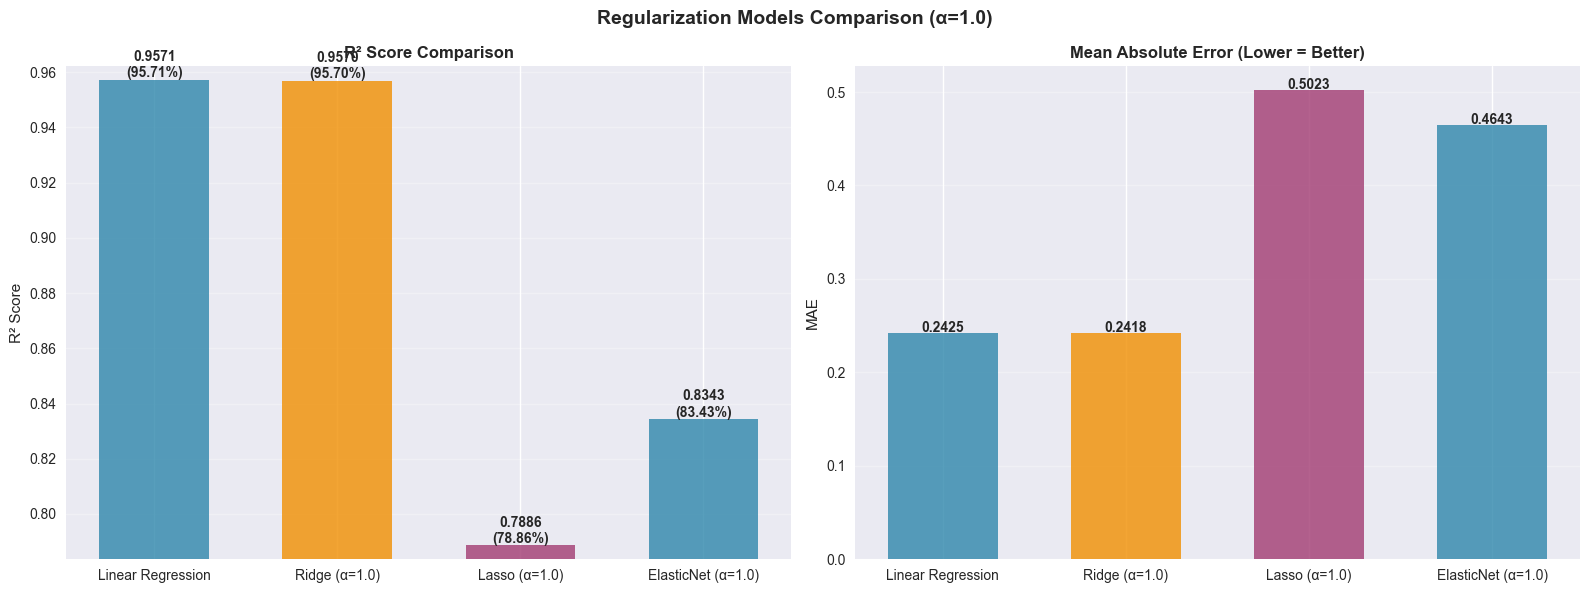

In [79]:
# Regularization Results Analysis
print("\n" + "="*70)
print("REGULARIZATION COMPARISON SUMMARY")
print("="*70)

# Results table
print(f"\n{'Model':<25} {'R² Score':<12} {'Accuracy %':<12} {'MAE':<8} {'RMSE':<8}")
print("-" * 70)

r2_values = [regularization_results[k]['R2'] for k in regularization_results.keys()]
max_r2, min_r2 = max(r2_values), min(r2_values)
is_tie = abs(max_r2 - min_r2) < 1e-4

for model, metrics in regularization_results.items():
    r2, mae, rmse = metrics['R2'], metrics['MAE'], metrics['RMSE']
    status = "TIE" if is_tie else ("WINNER" if abs(r2 - max_r2) < 1e-6 else "")
    print(f"{model:<25} {r2:<12.4f} {r2*100:<12.2f} {mae:<8.4f} {rmse:<8.4f} {status}")

# Analysis
print(f"\nANALYSIS:")
if is_tie:
    print(f"• All models perform similarly (difference < 0.01%)")
    print(f"• Default alpha=1.0 may be too strong for this dataset")
    print(f"• Linear regression baseline is competitive")
else:
    winner = max(regularization_results.keys(), key=lambda k: regularization_results[k]['R2'])
    improvement = ((max_r2 - min_r2) / min_r2) * 100
    print(f"• WINNER: {winner}")
    print(f"• Best R² Score: {max_r2:.4f} ({max_r2*100:.2f}% accuracy)")
    print(f"• Performance Improvement: {improvement:.3f}%")

print(f"\nFEATURE SELECTION EFFECTS:")
print(f"• Original features: {len(selected_feature_names)}")
print(f"• Lasso selected: {lasso_selected_features}")
print(f"• ElasticNet selected: {elastic_selected_features}")
print(f"• Ridge: Uses all features (coefficients shrunk, not eliminated)")

# Visualization
create_comparison_visualization(
    regularization_results,
    'Regularization Models Comparison (α=1.0)',
    figsize=(16, 6)
)

## 📈 Alpha Tuning: Finding Optimal Regularization Strength

The default alpha=1.0 might be too strong. Let's test different alpha values to find the optimal regularization strength for each model.

In [80]:
# Alpha Tuning Analysis
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
alpha_results = {'Ridge': {}, 'Lasso': {}, 'ElasticNet': {}}

print("ALPHA TUNING FOR REGULARIZATION MODELS")
print("="*60)
print(f"Testing alpha values: {alpha_values}")
print()

# Test Ridge with different alphas
print("RIDGE REGRESSION ALPHA TUNING:")
print("-" * 40)
ridge_r2_scores = []
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train_best, y_train)
    y_pred = ridge.predict(X_test_best)
    r2 = r2_score(y_test, y_pred)
    ridge_r2_scores.append(r2)
    alpha_results['Ridge'][alpha] = r2
    print(f"α={alpha:6.3f}: R² = {r2:.4f} ({r2*100:.2f}%)")

best_ridge_alpha = alpha_values[np.argmax(ridge_r2_scores)]
best_ridge_r2 = max(ridge_r2_scores)
print(f"BEST Ridge: α={best_ridge_alpha}, R² = {best_ridge_r2:.4f}")

# Test Lasso with different alphas
print(f"\nLASSO REGRESSION ALPHA TUNING:")
print("-" * 40)
lasso_r2_scores = []
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=2000)
    lasso.fit(X_train_best, y_train)
    y_pred = lasso.predict(X_test_best)
    r2 = r2_score(y_test, y_pred)
    lasso_r2_scores.append(r2)
    alpha_results['Lasso'][alpha] = r2
    print(f"α={alpha:6.3f}: R² = {r2:.4f} ({r2*100:.2f}%)")

best_lasso_alpha = alpha_values[np.argmax(lasso_r2_scores)]
best_lasso_r2 = max(lasso_r2_scores)
print(f"BEST Lasso: α={best_lasso_alpha}, R² = {best_lasso_r2:.4f}")

# Test ElasticNet with different alphas (fixed l1_ratio=0.5)
print(f"\nELASTICNET REGRESSION ALPHA TUNING:")
print("-" * 40)
elastic_r2_scores = []
for alpha in alpha_values:
    elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, random_state=42, max_iter=2000)
    elastic.fit(X_train_best, y_train)
    y_pred = elastic.predict(X_test_best)
    r2 = r2_score(y_test, y_pred)
    elastic_r2_scores.append(r2)
    alpha_results['ElasticNet'][alpha] = r2
    print(f"α={alpha:6.3f}: R² = {r2:.4f} ({r2*100:.2f}%)")

best_elastic_alpha = alpha_values[np.argmax(elastic_r2_scores)]
best_elastic_r2 = max(elastic_r2_scores)
print(f"BEST ElasticNet: α={best_elastic_alpha}, R² = {best_elastic_r2:.4f}")

# Summary
print(f"\n" + "="*60)
print("ALPHA TUNING SUMMARY")
print("="*60)
print(f"{'Model':<15} {'Best Alpha':<12} {'Best R²':<12} {'Accuracy %'}")
print("-" * 55)
print(f"{'Ridge':<15} {best_ridge_alpha:<12} {best_ridge_r2:<12.4f} {best_ridge_r2*100:.2f}%")
print(f"{'Lasso':<15} {best_lasso_alpha:<12} {best_lasso_r2:<12.4f} {best_lasso_r2*100:.2f}%")
print(f"{'ElasticNet':<15} {best_elastic_alpha:<12} {best_elastic_r2:<12.4f} {best_elastic_r2*100:.2f}%")

# Compare with baseline
baseline_r2 = regularization_results['Linear Regression']['R2']
print(f"{'Linear (baseline)':<15} {'None':<12} {baseline_r2:<12.4f} {baseline_r2*100:.2f}%")

overall_best = max(best_ridge_r2, best_lasso_r2, best_elastic_r2, baseline_r2)
if overall_best == best_ridge_r2:
    overall_winner = f"Ridge (α={best_ridge_alpha})"
elif overall_best == best_lasso_r2:
    overall_winner = f"Lasso (α={best_lasso_alpha})"
elif overall_best == best_elastic_r2:
    overall_winner = f"ElasticNet (α={best_elastic_alpha})"
else:
    overall_winner = "Linear Regression (no regularization)"

print(f"\nOVERALL WINNER: {overall_winner}")
print(f"Best R² Score: {overall_best:.4f} ({overall_best*100:.2f}% accuracy)")

ALPHA TUNING FOR REGULARIZATION MODELS
Testing alpha values: [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

RIDGE REGRESSION ALPHA TUNING:
----------------------------------------
α= 0.001: R² = 0.9571 (95.71%)
α= 0.010: R² = 0.9571 (95.71%)
α= 0.100: R² = 0.9571 (95.71%)
α= 0.500: R² = 0.9570 (95.70%)
α= 1.000: R² = 0.9570 (95.70%)
α= 5.000: R² = 0.9566 (95.66%)
α=10.000: R² = 0.9563 (95.63%)
α=50.000: R² = 0.9531 (95.31%)
α=100.000: R² = 0.9480 (94.80%)
BEST Ridge: α=0.001, R² = 0.9571

LASSO REGRESSION ALPHA TUNING:
----------------------------------------
α= 0.001: R² = 0.9568 (95.68%)
α= 0.010: R² = 0.9564 (95.64%)
α= 0.100: R² = 0.9426 (94.26%)
α= 0.500: R² = 0.8436 (84.36%)
α= 1.000: R² = 0.7886 (78.86%)
α= 5.000: R² = -0.0029 (-0.29%)
α=10.000: R² = -0.0029 (-0.29%)
α=50.000: R² = -0.0029 (-0.29%)
α=100.000: R² = -0.0029 (-0.29%)
BEST Lasso: α=0.001, R² = 0.9568

ELASTICNET REGRESSION ALPHA TUNING:
----------------------------------------
α= 0.001: R² = 0.9568 (95.68%)
α

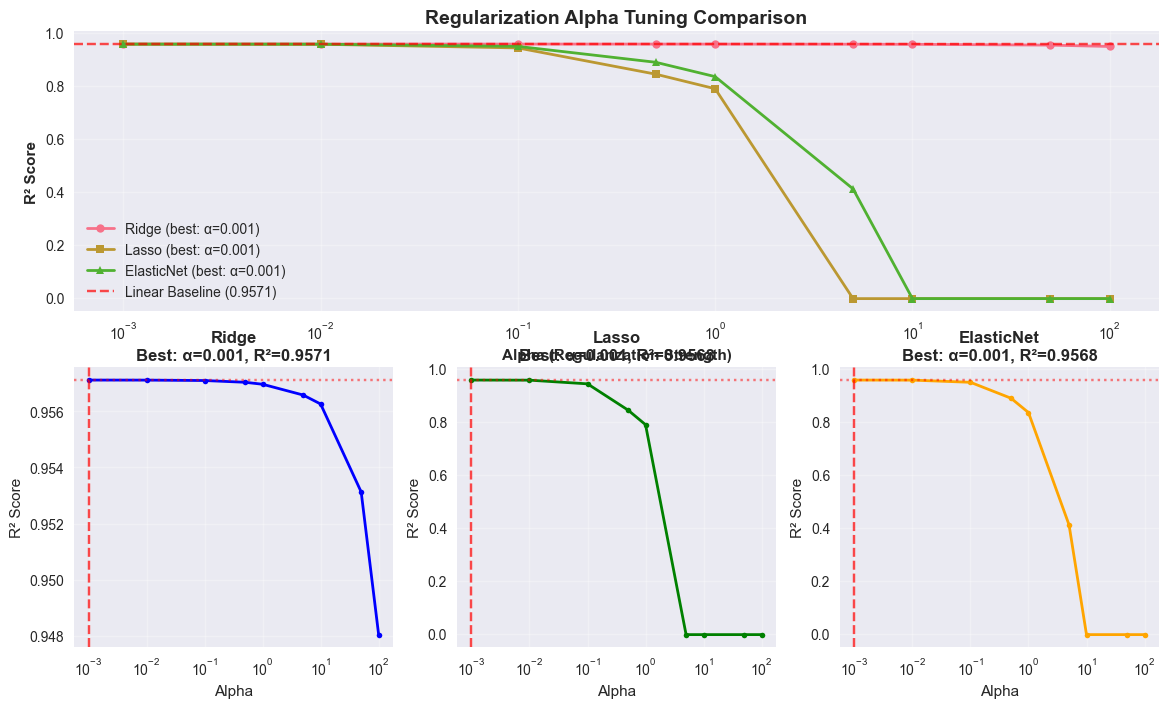


REGULARIZATION ANALYSIS CONCLUSIONS:
• Ridge improvement: -0.000%
• Lasso improvement: -0.030%
• ElasticNet improvement: -0.029%

FINDING: Regularization provides minimal benefit (<0.1% improvement)
This suggests the dataset is not overfitting with linear regression.
The SelectKBest feature selection already provides good generalization.


In [81]:
# Alpha Tuning Visualization
plt.figure(figsize=(14, 8))

# Main plot: R² vs Alpha
plt.subplot(2, 2, (1, 2))
plt.semilogx(alpha_values, ridge_r2_scores, 'o-', label=f'Ridge (best: α={best_ridge_alpha})', linewidth=2, markersize=6)
plt.semilogx(alpha_values, lasso_r2_scores, 's-', label=f'Lasso (best: α={best_lasso_alpha})', linewidth=2, markersize=6)
plt.semilogx(alpha_values, elastic_r2_scores, '^-', label=f'ElasticNet (best: α={best_elastic_alpha})', linewidth=2, markersize=6)
plt.axhline(y=baseline_r2, color='red', linestyle='--', alpha=0.7, label=f'Linear Baseline ({baseline_r2:.4f})')

plt.xlabel('Alpha (Regularization Strength)', fontweight='bold')
plt.ylabel('R² Score', fontweight='bold')
plt.title('Regularization Alpha Tuning Comparison', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Individual model plots
models = ['Ridge', 'Lasso', 'ElasticNet']
colors = ['blue', 'green', 'orange']
best_alphas = [best_ridge_alpha, best_lasso_alpha, best_elastic_alpha]
best_r2s = [best_ridge_r2, best_lasso_r2, best_elastic_r2]

for i, (model, color, best_alpha, best_r2) in enumerate(zip(models, colors, best_alphas, best_r2s)):
    plt.subplot(2, 3, i + 4)
    r2_scores = [alpha_results[model][alpha] for alpha in alpha_values]
    plt.semilogx(alpha_values, r2_scores, 'o-', color=color, linewidth=2, markersize=4)
    plt.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7)
    plt.axhline(y=baseline_r2, color='red', linestyle=':', alpha=0.5)
    plt.xlabel('Alpha')
    plt.ylabel('R² Score')
    plt.title(f'{model}\nBest: α={best_alpha}, R²={best_r2:.4f}', fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance Summary
print(f"\nREGULARIZATION ANALYSIS CONCLUSIONS:")
print(f"="*50)

# Check if regularization helps
improvement_ridge = ((best_ridge_r2 - baseline_r2) / baseline_r2) * 100
improvement_lasso = ((best_lasso_r2 - baseline_r2) / baseline_r2) * 100  
improvement_elastic = ((best_elastic_r2 - baseline_r2) / baseline_r2) * 100

print(f"• Ridge improvement: {improvement_ridge:+.3f}%")
print(f"• Lasso improvement: {improvement_lasso:+.3f}%")
print(f"• ElasticNet improvement: {improvement_elastic:+.3f}%")

if max(improvement_ridge, improvement_lasso, improvement_elastic) < 0.1:
    print(f"\nFINDING: Regularization provides minimal benefit (<0.1% improvement)")
    print(f"This suggests the dataset is not overfitting with linear regression.")
    print(f"The SelectKBest feature selection already provides good generalization.")
else:
    print(f"\nFINDING: Regularization provides meaningful improvement")
    print(f"Consider using the best-performing regularized model.")